<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/07_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Word Embeddings

We’ll start our NLP journey by following the steps of Alice and Dorothy, from
[Alice’s Adventures in Wonderland](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1476) by Lewis Carroll and [The Wonderful Wizard of Oz](https://ota.bodleian.ox.ac.uk/repository/xmlui/handle/20.500.12024/1740) by L. Frank Baum.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/alice_dorothy.png?raw=1)

*Left: "Alice and the Baby Pig" illustration by John Tenniel's, from "Alice's Adventure's in Wonderland" (1865).*

*Right: "Dorothy meets the Cowardly Lion" illustration by W.W. Denslow, from "The Wonderful Wizard of Oz" (1900)*

##Setup

In [1]:
%%capture

# # UPDATED
# ###########################################################
!pip install gensim==4.3.1
# # The library has been archived and won't be used anymore
# # # !pip install allennlp==0.9.0
#!pip install flair==0.12.2
#!pip install torchvision==0.15.1
# # # HuggingFace
!pip install transformers==4.32.0
!pip install datasets==2.14.4
# ###########################################################
!pip -q install spacy
!python -m spacy download en_core_web_sm

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

Finished!


In [3]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 10
from seq2seq import *

import spacy
import nltk
from nltk.tokenize import sent_tokenize

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [6]:
from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

##Downloading Books

In [7]:
!rm -rf data

In [8]:
# let's download data
HOME_DIR = "data"
download_text(ALICE_URL, HOME_DIR)
download_text(WIZARD_URL, HOME_DIR)

In [9]:
# let's see the downloaded data
#!cat data/alice28-1476.txt

In [10]:
#!cat data/wizoz10-1740.txt

We need to remove these additions to the original texts:

In [11]:
alice_file = os.path.join(HOME_DIR, "alice28-1476.txt")
with open(alice_file, "r") as f:
  # The actual texts of the books are contained between lines 105 and 3703
  alice_text = "".join(f.readlines()[104:3704])

wizard_file = os.path.join(HOME_DIR, "wizoz10-1740.txt")
with open(wizard_file, "r") as f:
  # The actual texts of the books are contained between lines 309 and 5099
  wizard_text = "".join(f.readlines()[310:5100])

In [12]:
print(alice_text[:500])
print("\n", "#"*70, "\n")
print(wizard_text[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w

 ###################################################################### 

                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking

We can partially automate the removal of the extra lines by setting the real start and end lines of each text in a configuration file.

In [13]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(HOME_DIR, 'lines.cfg'), 'w').write(text_cfg)

##Sentence Tokenization

A token is a piece of a text, and to tokenize a text means to split
it into pieces; that is, into a list of tokens.

The most common kind of piece is a word.

So, tokenizing a text usually means to
split it into words using the white space as a separator.

In [14]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(" ")
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

Let's do sentence tokenization, which means to split a text into its sentences.

In [15]:
corpus_alice = sent_tokenize(alice_text)
corpus_wizard = sent_tokenize(wizard_text)

len(corpus_alice), (len(corpus_wizard))

(1612, 2240)

Let’s check one sentence from the first corpus of text.

In [16]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

Let’s check one sentence from the second corpus of text.

In [17]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

Our dataset is going to be a collection of CSV files, one file for each book, with each
CSV file containing one sentence per line.

Therefore, we need to:

* clean the line breaks to make sure each sentence is on one line only;
* define an appropriate quote char to "wrap" the sentence such that the original commas and semicolons in the original text do not get misinterpreted as separation chars of the CSV file; and
* add a second column to the CSV file to
identify the original source of the sentence since we’ll be concatenating, and
shuffling the sentences before training a model on our corpora.

The sentence above should end up looking like this:
```log
\"There's a cyclone coming, Em," he called to his wife.\,wizoz10-1740.txt
```

The function below does the grunt work of cleaning, splitting, and saving the
sentences to a CSV file for us:

In [18]:
def sentence_tokenize(source, quote_char="\\", sep_char=",", include_header=True, include_source=True, extensions=("txt"), **kwargs):
  # If source is a folder, goes through all files inside it that match the desired extensions ('txt' by default)
  if os.path.isdir(source):
    filenames = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f)) and os.path.splitext(f)[1][1:] in extensions]
  elif isinstance(source, str):
    filenames = [source]

  # If there is a configuration file, builds a dictionary with the corresponding start and end lines of each text file
  config_file = os.path.join(source, "lines.cfg")
  config = {}
  if os.path.exists(config_file):
    with open(config_file, "r") as f:
      rows = f.readlines()
    for r in rows[1:]:
      fname, start, end = r.strip().split(",")
      config.update({fname: (int(start), int(end))})

  new_fnames = []
  # For each file of text
  for fname in filenames:
    # If there's a start and end line for that file, use it
    try:
        start, end = config[fname]
    except KeyError:
        start = None
        end = None

    # Opens the file, slices the configures lines (if any)
    # cleans line breaks and uses the sentence tokenizer
    with open(os.path.join(source, fname), 'r') as f:
        contents = (''.join(f.readlines()[slice(start, end, None)]).replace('\n', ' ').replace('\r', ''))
    corpus = sent_tokenize(contents, **kwargs)

    # Builds a CSV file containing tokenized sentences
    base = os.path.splitext(fname)[0]
    new_fname = f'{base}.sent.csv'
    new_fname = os.path.join(source, new_fname)
    with open(new_fname, 'w') as f:
        # Header of the file
        if include_header:
            if include_source:
                f.write('sentence,source\n')
            else:
                f.write('sentence\n')
        # Writes one line for each sentence
        for sentence in corpus:
            if include_source:
                f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
            else:
                f.write(f'{quote_char}{sentence}{quote_char}\n')
    new_fnames.append(new_fname)

  # Returns list of the newly generated CSV files
  return sorted(new_fnames)

In [19]:
new_fnames = sentence_tokenize(HOME_DIR)
new_fnames

['data/alice28-1476.sent.csv', 'data/wizoz10-1740.sent.csv']

##Spacy sentence tokenization

In [20]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

sentences = []
for doc in nlp.pipe(corpus_alice):
  sentences.extend(sent.text for sent in doc.sents)

len(sentences), sentences[2]

(1615,
 'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!')

##HuggingFace’s Dataset

In [21]:
# let's load from local files using HuggingFace
dataset = load_dataset(path="csv", data_files=new_fnames, quotechar="\\", split=Split.TRAIN)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
# let's see attributes, like features, num_columns, and shape
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

In [23]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [24]:
dataset["sentence"][:3]

["                ALICE'S ADVENTURES IN WONDERLAND                            Lewis Carroll                 THE MILLENNIUM FULCRUM EDITION 2.8                                 CHAPTER I                        Down the Rabbit-Hole     Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do:  once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice `without pictures or conversation?'",
 'So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.',
 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!']

In [25]:
dataset["source"][:3]

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

In [26]:
# check the unique sources
dataset.unique("source")

['alice28-1476.txt', 'wizoz10-1740.txt']

In [27]:
# let's create new columns
def is_alice_label(row):
  is_alice = int(row["source"] == "alice28-1476.txt")
  return {"label": is_alice}

In [28]:
dataset = dataset.map(is_alice_label)

Map:   0%|          | 0/3852 [00:00<?, ? examples/s]

In [29]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt',
 'label': 1}

In [30]:
# Now, we can finally shuffle the dataset and split it into training and test sets
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'source', 'label'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['sentence', 'source', 'label'],
        num_rows: 771
    })
})

In [31]:
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

In [32]:
train_dataset[0]

{'sentence': 'After the first few whirls around, and one other time when the house tipped badly, she felt as if she were being rocked gently, like a baby in a cradle.',
 'source': 'wizoz10-1740.txt',
 'label': 0}

##Vocabulary

In [33]:
sentences = train_dataset["sentence"]
tokens = [simple_preprocess(sent) for sent in sentences]

In [34]:
# build a vocabulary
dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<3682 unique tokens: ['after', 'and', 'around', 'as', 'baby']...>


In [35]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['after', 'and', 'around', 'as', 'baby']

In [36]:
# add special token to unknown word
special_tokens = {
    "[PAD]": 0,
    "[UNK]": 1
}

dictionary.patch_with_special_tokens(special_tokens)

In [37]:
def get_rare_ids(dictionary, min_freq):
  rare_ids = [t[0] for t in dictionary.cfs.items() if t[1] < min_freq]
  return rare_ids

In [38]:
def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):

  if folder is not None:
    if not os.path.exists(folder):
      os.mkdir(folder)

  # tokenizes the sentences and create a Dictionary
  tokens = [simple_preprocess(sent) for sent in sentences]
  dictionary = corpora.Dictionary(tokens)

  # keeps only the most frequent words (vocab size)
  if vocab_size is not None:
    dictionary.filter_extremes(keep_n=vocab_size)

  # removes rare words (in case the vocab size still includes words with low frequency)
  if min_freq is not None:
    rare_tokens = get_rare_ids(dictionary, min_freq)
    dictionary.filter_tokens(bad_ids=rare_tokens)

  # gets the whole list of tokens and frequencies
  items = dictionary.cfs.items()

  # sorts the tokens in descending order
  words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]

  # prepends special tokens, if any
  if special_tokens is not None:
    to_add = []
    for special_token in special_tokens:
      if special_token not in words:
        to_add.append(special_token)
    words = to_add + words

  with open(os.path.join(folder, "vocab.txt"), "w") as f:
    for word in words:
      f.write(f"{word}\n")

In [39]:
make_vocab(
    train_dataset["sentence"],
    "our_vocab/",
    special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'],
    min_freq=2
)

## HugginFace's Tokenizer

So, before loading a pre-trained tokenizer, let’s create our own tokenizer using our
own vocabulary.

In [40]:
tokenizer = BertTokenizer("our_vocab/vocab.txt")

Let’s apply our tokenizer to our dataset of sentences, padding them and
returning PyTorch tensors:

In [41]:
tokenized_dataset = tokenizer(dataset["sentence"],
                              padding=True,
                              return_tensors="pt",
                              max_length=50,
                              truncation=True)
tokenized_dataset["input_ids"]

tensor([[   3,   27,    1,  ...,  100, 1044,    2],
        [   3,   23,   10,  ..., 1250,    5,    2],
        [   3,   45,   12,  ...,    0,    0,    0],
        ...,
        [   3,    1,    6,  ...,    0,    0,    0],
        [   3,    6,  126,  ...,    0,    0,    0],
        [   3,    1,    1,  ...,    0,    0,    0]])

Can we feed the input_ids to BERT and watch the magic happen?

BERT is actually using vectors to represent the words. The
token IDs we’ll be sending it are simply the indices of an enormous lookup table.

That lookup table has a very nice name: **Word Embeddings**.

Each row of the lookup table corresponds to a different token, and each row is
represented by a vector. The size of the vectors is the dimensionality of the
embedding.

##Text representation

Before getting to the actual word embeddings, let’s start with the basics and text representations.

###One-Hot Encoding

The idea behind OHE is quite simple: Each unique token (word) is represented by a vector full of zeros except for one position, which corresponds to the token’s index.

Let’s see one-hot encoding representations for 5 words.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/ohe1.png?raw=1)

But there are 3,704 unique tokens in our text
corpora (not counting the added special tokens), so the OHE actually looks like this.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/ohe2.png?raw=1)

That’s quite a large and sparse vector, right?

Clearly, this isn’t very practical.

Nonetheless, the sparse vectors produced by the one-hot
encoding are the basis of a fairly basic NLP model: the bag-of-words (BoW).

###Bag-of-Words

The bag-of-words model is literally a bag of words: It simply sums up the
corresponding OHE vectors, completely disregarding any underlying structure or
relationships between the words.

In [42]:
sentence = "the white rabbit is a rabbit"
bow_tokens = simple_preprocess(sentence)
bow_tokens

['the', 'white', 'rabbit', 'is', 'rabbit']

In [43]:
bow = dictionary.doc2bow(bow_tokens)
bow

[(20, 1), (217, 1), (738, 2), (910, 1)]

Representing words using
one-hot-encoded vectors also presents severe limitations: Not only do the vectors become more and more sparse (that is, have more zeros in them) as the vocabulary
grows, but also every word is orthogonal to all the other words.

If we use one-hot-encoded vectors to represent words, we’re
basically saying that no two words are similar to each other.

##Word Embeddings

Word2Vec has two model architectures: continuous bag-of-words (CBoW) and skip-gram (SG).

###Word2Vec

In [44]:
class CBOW(nn.Module):
  def __init__(self, vocab_size, embedding_size):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.linear = nn.Linear(embedding_size, vocab_size)

  def forward(self, X):
    embeddings = self.embedding(X)
    bow = embeddings.mean(dim=1)
    logits = self.linear(bow)
    return logits

If our vocabulary had only five words ("the,"
"small," "is," "barking," and "dog"), we could try to represent each word with an
embedding of three dimensions.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/cbow.png?raw=1)

In [45]:
torch.manual_seed(42)

dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/w2v_embed.png?raw=1)

PyTorch’s `nn.Embedding` layer is a large lookup table.To actually
retrieve the values, we need to call the embedding layer with a list of token
indices, and it will return the corresponding rows of the table.

Let's retrieve the embeddings for the tokens "is" and "barking" using
their corresponding indices (two and three):

In [46]:
# tokens: ['is', 'barking']
dummy_cbow.embedding(torch.as_tensor([2, 3]))

tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], grad_fn=<EmbeddingBackward0>)

That’s why the main job of the tokenizer is to transform a
sentence into a list of token IDs. That list is used as an input to
the embedding layer, and from then on, the tokens are
represented by dense vectors.

In our former example, "dog" was the central word and the other four words were the context words:

In [47]:
tiny_vocab = ["the", "small", "is", "barking", "dog"]
context_words = ["the", "small", "is", "barking"]
target_words = ["dog"]

Now, let’s pretend that we tokenized the words and got their corresponding
indices:

In [48]:
batch_context = torch.as_tensor([[0, 1, 2, 3]]).long()
batch_target = torch.as_tensor([[4]]).long()

In its very first training step, the model would compute the continuous bag-ofwords
for the inputs by averaging the corresponding embeddings.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/w2v_cbow.png?raw=1)

In [49]:
cbow_features = dummy_cbow.embedding(batch_context).mean(dim=1)
cbow_features

tensor([[ 0.7606, -0.2743,  0.3298]], grad_fn=<MeanBackward1>)

The bag-of-words has three dimensions, which are the features used to compute
the logits for our multiclass classification problem.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/w2v_logits.png?raw=1)

In [50]:
logits = dummy_cbow.linear(cbow_features)
logits

tensor([[ 0.3542,  0.6937, -0.2028, -0.5873,  0.2099]],
       grad_fn=<AddmmBackward0>)

The largest logit corresponds to the word "small" (class index one), so that would be
the predicted central word: "The small small is barking." The prediction is obviously
wrong, but, then again, that’s still a randomly initialized model.

Given a large enough dataset of context and target words, we could train the CBOW model above using an `nn.CrossEntropyLoss()` to learn actual word embeddings.

###What Is an Embedding

An embedding is a representation of an entity (a word, in our case), and each of its
dimensions can be seen as an attribute or feature.

Let’s forget about words for a moment and talk about restaurants instead. We can
rate restaurants over many different dimensions, like food, price, and service, for
example.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rest_discrete.png?raw=1)

Although it’s fairly obvious to spot the similarities and differences among the restaurants in the table above, it wouldn’t be so easy to spot them if there were dozens of dimensions to compare.

Besides, it would be very hard to objectively
measure the similarity between any two restaurants using categorical scales like that.

What if we use continuous scales instead?

Perfect! Let’s do that and assign values in the range [-1, 1], from very bad (-1) to
very good (1), or from very expensive (-1) to very cheap (1).


![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rest_continuous.png?raw=1)

These values are like "restaurant embeddings" :-)

Well, they’re not quite embeddings, but at least we can use cosine similarity to find
out how similar to each other two restaurants are:

In [51]:
ratings = torch.as_tensor([
    [.7, -.4, .7],
    [.3, .7, -.5],
    [.9, -.55, .8],
    [-.3, .8, .34]
]).float()

sims = torch.zeros(4, 4)
for i in range(4):
  for j in range(4):
    sims[i, j] = F.cosine_similarity(ratings[i], ratings[j], dim=0)
sims

tensor([[ 1.0000, -0.4318,  0.9976, -0.2974],
        [-0.4318,  1.0000, -0.4270,  0.3581],
        [ 0.9976, -0.4270,  1.0000, -0.3598],
        [-0.2974,  0.3581, -0.3598,  1.0000]])

Although we can compute the cosine similarity between two restaurants now, the
values in the table above are not real embeddings. It was only an example that
illustrates well the concept of embedding dimensions as attributes.

###Global Vectors (GloVe)

The Global Vectors model combines the skip-gram
model with co-occurrence statistics at the global level (hence the name).

In [52]:
# Downloading Pre-trained Word Embeddings
glove = downloader.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [53]:
# UPDATED
###########################################################
# The vocab property isn't available anymore at the newer
# Gensim version. It was replaced by key_to_index len(glove.vocab)
len(glove.key_to_index)
###########################################################

400000

In [54]:
# Let’s check the embeddings for "alice"
glove["alice"]

array([ 0.16386 ,  0.57795 , -0.59197 , -0.32446 ,  0.29762 ,  0.85151 ,
       -0.76695 , -0.20733 ,  0.21491 , -0.51587 , -0.17517 ,  0.94459 ,
        0.12705 , -0.33031 ,  0.75951 ,  0.44449 ,  0.16553 , -0.19235 ,
        0.065533, -0.12394 ,  0.61446 ,  0.89784 ,  0.17413 ,  0.41149 ,
        1.191   , -0.39461 , -0.459   ,  0.022161, -0.50843 , -0.44464 ,
        0.68721 , -0.7167  ,  0.20835 , -0.23437 ,  0.02604 , -0.47993 ,
        0.31873 , -0.29135 ,  0.50273 , -0.55144 , -0.066692,  0.43873 ,
       -0.24293 , -1.0247  ,  0.029375,  0.068499,  0.25451 , -1.9663  ,
        0.26673 ,  0.88486 ], dtype=float32)

In [55]:
len(glove["alice"])

50

In [56]:
# let's create a synthetic queen
synthetic_queen = glove["king"] - glove["man"] + glove["woman"]

/content/plots/chapter11.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(['', word, ''])


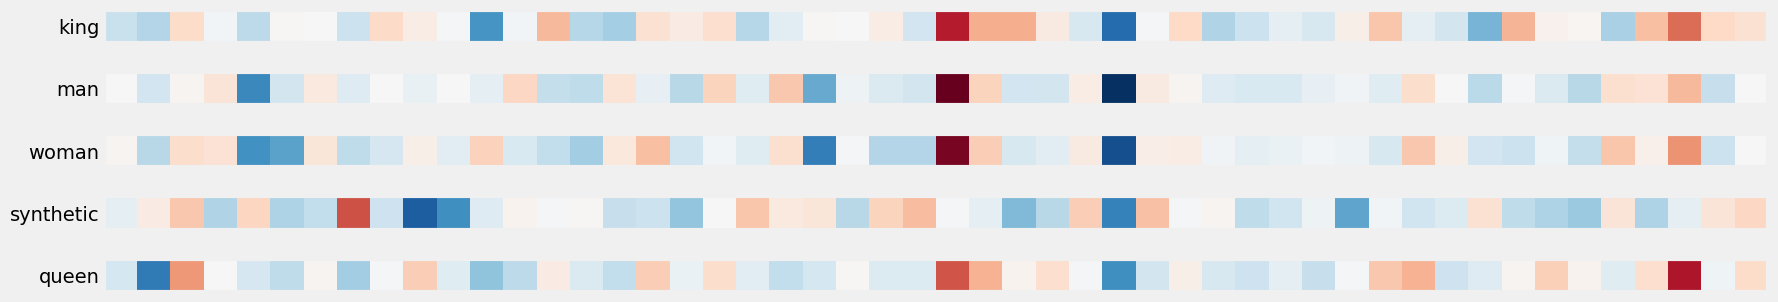

In [57]:
# These are the corresponding embeddings
fig = plot_word_vectors(
    glove, ["king", "man", "woman", "synthetic", "queen"],
    other = {"synthetic_queen": synthetic_queen}
)

How similar is the "synthetic queen" to the actual "queen,"?

In [58]:
glove.similar_by_vector(synthetic_queen, topn=5)

[('king', 0.8859834671020508),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634970545768738)]

The most similar word to the 'synthetic queen' is … king?

Yes.after performing word embedding arithmetic, the word most similar to the result is the original word itself.

For this reason, it’s usual to exclude the original word from the
similarity results. In this case, the most similar word to the "synthetic queen" is,
indeed, the actual "queen."

In [59]:
glove.similar_by_vector(synthetic_queen, topn=5)[1:]

[('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634970545768738)]

###Using Word Embeddings

What if the vocabulary of your corpora is not quite properly
represented in the embeddings?

Even worse, what if the preprocessing steps you
used resulted in a lot of tokens that do not exist in the embeddings?

First and foremost, most of the usual
preprocessing steps do not apply when you’re using pre-trained word embeddings
like GloVe: no lemmatization, no stemming, no stop-word removal. These steps
would likely end up producing a lot of `[UNK]` tokens.

Second, even without those preprocessing steps, maybe the words used in the
given text corpora are simply not a good match for a particular pre-trained set of word embeddings.

Let’s see how good a match the glove-wiki-gigaword-50 embeddings are to our
own vocabulary.

In [60]:
vocab = list(dictionary.token2id.keys())
len(vocab)

3684

Let’s see how many words of our own vocabulary are unknown to the
embeddings:

In [61]:
unknown_words = sorted(list(set(vocab).difference(set(glove.key_to_index))))
print(len(unknown_words))
print(unknown_words[:5])

43
['[PAD]', '[UNK]', 'arrum', 'barrowful', 'beauti']


If we look at how often the unknown words show up in our text corpora, we’ll have
a precise measure of how many tokens will be unknown to the embeddings.

In [62]:
# get the IDs of the unknown words first
unknown_ids = [dictionary.token2id[w] for w in unknown_words if w not in ["[PAD]", "[UNK]"]]
# then look at their frequencies in the corpora
unknown_count = sum(dictionary.cfs[idx] for idx in unknown_ids)
unknown_count, dictionary.num_pos

(87, 50598)

Only 86 out of 50,749 words in the text corpora cannot be matched to the
vocabulary of the word embeddings. That’s an impressive 99.84% coverage!

Let's compute the vocabulary coverage given
a Gensim’s Dictionary and pre-trained embeddings.

In [63]:
def vocab_coverage(gensim_dict, pretrained_wv, special_tokens=["[PAD]", "[UNK]"]):
  vocab = list(gensim_dict.token2id.keys())
  # get the vocabulary of unknown embeddings
  unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.key_to_index))))
  # get the IDs of the unknown words first
  unknown_ids = [gensim_dict.token2id[w] for w in unknown_words if w not in special_tokens]
  # then look at their frequencies in the corpora
  unknown_count = sum(gensim_dict.cfs[idx] for idx in unknown_ids)
  cov = 1 - unknown_count / gensim_dict.num_pos
  return cov

In [64]:
vocab_coverage(dictionary, glove)

0.9982805644491877

###Tokenizer

In [65]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
  if folder is not None:
    if not os.path.exists(folder):
      os.mkdir(folder)

  # UPDATED
  ###########################################################
  # The index2word property isn't available anymore at the newer Gensim version. It was replaced by index_to_key
  # words = wv.index2word
  words = wv.index_to_key
  ###########################################################
  if special_tokens is not None:
    to_add = []
    for special_token in special_tokens:
      if special_token not in words:
        to_add.append(special_token)
    words = to_add + words

  with open(os.path.join(folder, "vocab.txt"), "w") as f:
    for word in words:
      f.write(f"{word}\n")

In [66]:
# let's save the vocabulary of the embeddings to disk as a plain-text file
make_vocab_from_wv(glove, "glove_vocab/", special_tokens=["[PAD]", "[UNK]"])

In [67]:
# now, let's create a tokenizer based on GloVe’s vocabulary
glove_tokenizer = BertTokenizer("glove_vocab/vocab.txt")

In [68]:
# get the indices for the tokens
glove_tokenizer.encode("alice followed the white rabbit", add_special_tokens=False)

[7101, 930, 2, 300, 12427]

###Special Tokens' Embeddings

In [69]:
len(glove_tokenizer.vocab), len(glove.vectors)

(400002, 400000)

The difference is due to the two special tokens, `[PAD]` and `[UNK]`, that were prepended to the vocabulary when we saved it to disk. Therefore, we need to prepend their corresponding embeddings too.

In [70]:
# let's create 50-dimensional vectors of zeros
special_embeddings = np.zeros((2, glove.vector_size))

In [71]:
# and concatenate them to the GloVe’s pre-trained embeddings
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)
extended_embeddings.shape

(400002, 50)

In [72]:
# it should match the original GloVe embeddings
alice_index = glove_tokenizer.encode("alice", add_special_tokens=False)

np.all(extended_embeddings[alice_index] == glove["alice"])

True

Let’s put these embeddings to good use and finally train
a model in PyTorch!

## Model I - GloVe + Classifier

In [73]:
## Data Preparation
train_sentences = train_dataset["sentence"]
train_labels = train_dataset["label"]

test_sentences = test_dataset["sentence"]
test_labels = test_dataset["label"]

In [74]:
## Data Preparation — Tokenizing
train_ids = glove_tokenizer(
    train_sentences,
    truncation=True,
    padding=True,
    max_length=60,
    add_special_tokens=False,
    return_tensors="pt"
)["input_ids"]
train_labels = torch.as_tensor(train_labels).float().view(-1, 1)

test_ids = glove_tokenizer(
    test_sentences,
    truncation=True,
    padding=True,
    max_length=60,
    add_special_tokens=False,
    return_tensors="pt"
)["input_ids"]
test_labels = torch.as_tensor(test_labels).float().view(-1, 1)

In [75]:
## Data Preparation - Data Loader
train_tensor_dataset = TensorDataset(train_ids, train_labels)
generator = torch.Generator()

train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)

test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)

In [76]:
## Pre-trained PyTorch Embeddings
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

In [77]:
# let’s take the first mini-batch of tokenized sentences and their labels
token_ids, labels = next(iter(train_loader))
token_ids

tensor([[   2, 2656,  118,  ...,    0,    0,    0],
        [  10,   93,    9,  ...,    0,    0,    0],
        [ 934,   40,   34,  ...,    0,    0,    0],
        ...,
        [  65,   17,    9,  ...,    0,    0,    0],
        [  10,  740,    3,  ...,    0,    0,    0],
        [  10,   34,   83,  ...,    0,    0,    0]])

In [78]:
# let's retrieve their corresponding embeddings
token_embeddings = torch_embeddings(token_ids)
token_embeddings.shape

torch.Size([32, 60, 50])

In [79]:
# Let’s average the embeddings corresponding to all tokens in a sentence
token_embeddings.mean(dim=1)

tensor([[ 0.1275,  0.1861, -0.1406,  ..., -0.3492, -0.0292, -0.2021],
        [ 0.0220,  0.0194, -0.0149,  ..., -0.0498,  0.0366,  0.0485],
        [ 0.0196,  0.0431,  0.0261,  ..., -0.0323, -0.0042,  0.0620],
        ...,
        [ 0.0961,  0.0395, -0.0803,  ..., -0.0750, -0.0032,  0.0228],
        [ 0.0243,  0.0385, -0.0240,  ..., -0.0557,  0.0112,  0.1113],
        [ 0.0551,  0.0614,  0.0091,  ..., -0.0197,  0.0082,  0.1099]])

In [80]:
# The outcome is exactly the same as the one above, but it is faster
boe_mean = nn.EmbeddingBag.from_pretrained(extended_embeddings, mode="mean")
boe_mean(token_ids)

tensor([[ 0.1275,  0.1861, -0.1406,  ..., -0.3492, -0.0292, -0.2021],
        [ 0.0220,  0.0194, -0.0149,  ..., -0.0498,  0.0366,  0.0485],
        [ 0.0196,  0.0431,  0.0261,  ..., -0.0323, -0.0042,  0.0620],
        ...,
        [ 0.0961,  0.0395, -0.0803,  ..., -0.0750, -0.0032,  0.0228],
        [ 0.0243,  0.0385, -0.0240,  ..., -0.0557,  0.0112,  0.1113],
        [ 0.0551,  0.0614,  0.0091,  ..., -0.0197,  0.0082,  0.1099]])

In [81]:
## Model Configuration & Training
torch.manual_seed(41)

extended_embeddings = torch.as_tensor(extended_embeddings).float()
boe_mean = nn.EmbeddingBag.from_pretrained(extended_embeddings, mode="mean")

model = nn.Sequential(
    # Embeddings
    boe_mean,
    # Classifier
    nn.Linear(boe_mean.embedding_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [82]:
sbs_embedding = StepByStep(model, loss_fn, optimizer)
sbs_embedding.set_loaders(train_loader, test_loader)
sbs_embedding.train(20)

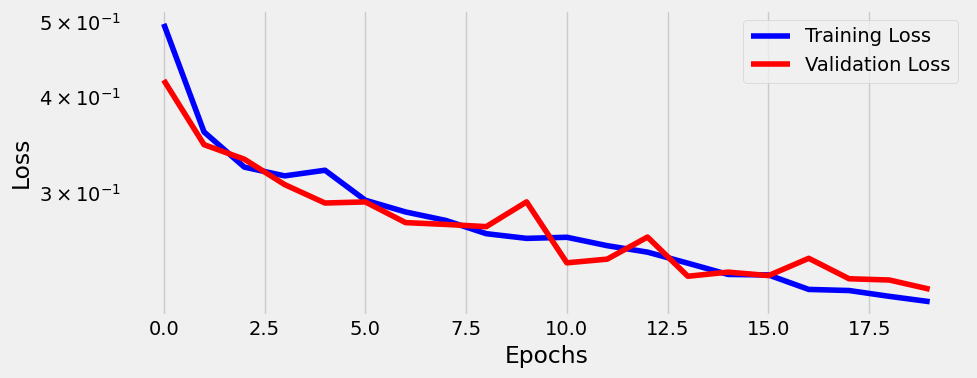

In [83]:
fig = sbs_embedding.plot_losses()

In [84]:
StepByStep.loader_apply(test_loader, sbs_embedding.correct)

tensor([[374, 412],
        [324, 359]])

## Model II - GloVe + Transformer

In [85]:
class TransformerClassifier(nn.Module):
  def __init__(self, embedding_layer, encoder, n_outputs):
    super().__init__()

    self.d_model = encoder.d_model
    self.n_outputs = n_outputs
    self.encoder = encoder
    self.mlp = nn.Linear(self.d_model, n_outputs)

    self.embedding = embedding_layer
    self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

  def preprocess(self, X):
    # N, L -> N, L, D
    src = self.embedding(X)
    # Special classifier token
    # 1, 1, D -> N, 1, D
    cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
    # Concatenates CLS tokens -> N, 1 + L, D
    src = torch.cat((cls_tokens, src), dim=1)
    return src

  def encode(self, source, source_mask=None):
    # Encoder generates "hidden states"
    states = self.encoder(source, source_mask)
    # Gets state from first token only: [CLS]
    cls_state = states[:, 0]  # N, 1, D
    return cls_state

  @staticmethod
  def source_mask(X):
    cls_mask = torch.ones(X.size(0), 1).type_as(X)
    pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
    return pad_mask.unsqueeze(1)

  def forward(self, X):
    src = self.preprocess(X)
    # Featurizer
    cls_state = self.encode(src, self.source_mask(X))
    # Classifier
    output = self.mlp(cls_state)  # N, 1, outputs
    return output

In [86]:
torch.manual_seed(33)

# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=2, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1)

# Uses both layers above to build our model
model = TransformerClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [87]:
sbs_transformer = StepByStep(model, loss_fn, optimizer)
sbs_transformer.set_loaders(train_loader, test_loader)
sbs_transformer.train(20)

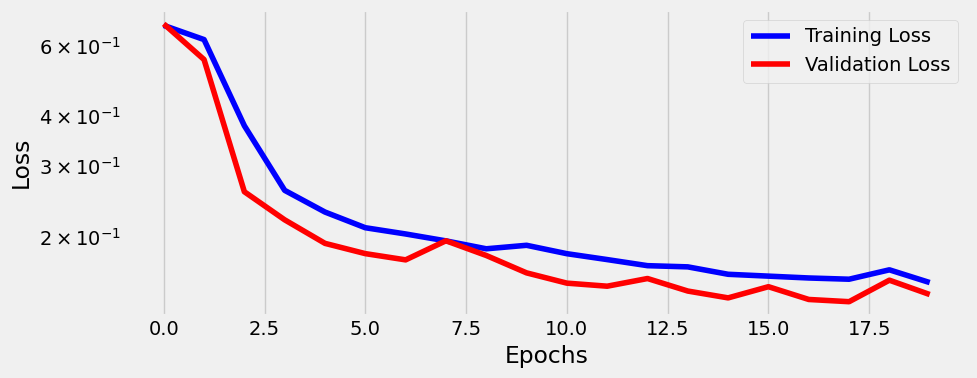

In [88]:
fig = sbs_transformer.plot_losses()

In [89]:
StepByStep.loader_apply(test_loader, sbs_transformer.correct)

tensor([[403, 412],
        [318, 359]])

## Visualizing Attention